In [306]:
import pandas as pd
import numpy as np
import os
import json
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import adjusted_mutual_info_score
import hdbscan
import matplotlib.pyplot as plt

from data_prep_scripts.data_countries import get_country_of_origin_data 
from data_prep_scripts.data_manipulation import df_replaceColVals_vars,process_remaining_categ_cols, read_enum_dict
from data_prep_scripts.process_repetitive_cols import get_repetitive_cols

## Load and preprocess raw data

In [4]:
# column we predict
col_to_predict = 'Triple Negative'
# preparing the df containing the raw data
medData = pd.read_excel('Merged File 2.5.19 De-identified.xlsx')
medData['Country of Origin for Father'].replace(76,'Ireland',inplace=True)
medData = medData[(medData['Breast Cancer?']=='Yes') & (medData['Gender'] == 'Female')]
medData = medData.applymap(lambda s:s.lower() if type(s) == str else s)
predCol = pd.read_excel('Additional BCD Info 3.1.19 De-identified.xlsx',usecols="A,DZ")
medData = medData.merge(predCol,left_on='ID #', right_on='ID #')
medData = medData[medData[col_to_predict]!='Unknown']

In [5]:
ind_repititive_blocks = [
    (47,89,7),(89,117,7),(117,152,7),
    (163,191,7),(197,213,4),(214,249,5),
    (294,348,6),(349,356,7),(357,364,7),
    (427,435,8)
]
ind_not_del = list(range(22,43)) + [274]
ind_to_del = [2,3,4,(8,11),13,451,(197,213),(349,356),(386,414),(448,469)]

In [6]:
# processes blocks of columns that contain the same type of information
# groups them and returns them in lists.
rep_cols = get_repetitive_cols(medData)
# remove empty blocks and replace block[1] with an empty list
# if there is no cont. element
rep_cols_np = [
    [
        (block[0].astype('int64').values, block[1].astype('float32').values)
        if isinstance(block[1],pd.DataFrame) and block[1].shape[1]>0 
        else (block[0].astype('int64').values,[]) for block in group  if block
    ] 
    for group in rep_cols
] 

In [7]:
# get features for country of origin columns
country_of_origin_data = get_country_of_origin_data(medData)

In [8]:
# mixed_cols=[]
# for ii, (a,b) in enumerate(medData.dtypes.iteritems()):
#     if b == object:
#         types = set([type(k) for k in list(medData[a].dropna() ) ])
#         if str in types and len(types)>1: 
#             print(ii,a,b)

In [9]:
# columns that should only contain real numbered values, but contain strings in the raw data.
# this part of the code saves such string values in a json file, where we can specify
# the values to replace them with.
mixedCols_write_strs = [92,121,126,131,136,141,146,151,152,192,294,303,416,417,418,446,449]
dict_replaceColVals = df_replaceColVals_vars(medData,mixedCols_write_strs,str_vals=True)

In [10]:
medData.replace(dict_replaceColVals,inplace=True)

In [11]:
# replace outlier values with the values given in the json file
# where we can specify the values to replace them with
dict_replaceColVals_cont = df_replaceColVals_vars(medData,str_vals=False, cont_vals=True)
for k,v in dict_replaceColVals_cont.items():
    k_l, v_l = [], []
    for key, val in v.items():
        k_l.append(float(key)); v_l.append(val)
    medData[k].replace(k_l,v_l,inplace=True)
        

/home/serkan/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/serkan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/serkan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/serkan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/serkan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [12]:
col_min_max_count = 250
val_count_threshold = 50
col_values_replace_OTH = defaultdict(lambda:[])
cols_to_del=[]
for c in ind_to_del: 
    if isinstance(c,tuple): cols_to_del += list(medData.columns[c[0]:c[1]])
    else: cols_to_del.append(medData.columns[c])

for ii, (a,b) in enumerate(medData.dtypes.iteritems()):
    # do not delete the column in repetitive blocks
    in_rep_block = False
    for block in ind_repititive_blocks: 
        if (ii>=block[0]) and (ii < block[1]): in_rep_block = True
            
    if (not in_rep_block) and (b == object) and (ii not in ind_not_del):
        col_counts = medData[a].value_counts()        
        col_max_count = col_counts.iloc[0]
        # the most frequent value of a column should occur at least 'col_min_max_count' times
        if col_max_count < col_min_max_count: cols_to_del.append(a)
        elif medData.shape[0]-col_max_count < col_min_max_count: cols_to_del.append(a)
#         # for the columns that we preserve, we replace values if their 
#         # frequency is not above the given threshold 'val_count_threshold'.
#         else:
#             vals_to_OTH = list(col_counts[col_counts<val_count_threshold].index)
#             if vals_to_OTH: 
#                 col_values_replace_OTH[a] = vals_to_OTH
# print(len(col_values_replace_OTH.keys()))
# print(col_values_replace_OTH.keys())
# print(len(cols_to_del))
# print(cols_to_del)

In [13]:
# I deleted the datetime values for now. Will be added in the next iterations.
cols_to_del += list(medData.select_dtypes(include=['datetime']))
# cols processed by the 'get_repetitive_cols()' function
cols_repetitive = sum([list(medData.columns[c[0]:c[1]]) for c in ind_repititive_blocks],[])


In [14]:
remaining_obj_cols = [
    k for k in medData.select_dtypes(include=['object']) 
        if (k not in cols_to_del + cols_repetitive +[col_to_predict]) and 
           (not medData[k].isnull().all() )    
]
remaining_float_cols = [
    k for k in medData.select_dtypes(include=['float64']) 
        if (k not in cols_to_del + cols_repetitive +[col_to_predict]) and 
           (not medData[k].isnull().all() )    
]

In [15]:
medData_categ = process_remaining_categ_cols(medData[remaining_obj_cols])
medData_float = medData[remaining_float_cols]

In [16]:
#rep_cols
#country_of_origin_data

In [17]:
# for i,k in enumerate(medData.columns):
#     if k in remaining_obj_cols: print(i)

## Create model's inputs

In [18]:
# training and validation splits (80% and 20% respectively)
n_patients = medData.shape[0]
temp_indices = np.arange(n_patients)
np.random.seed(0)
np.random.shuffle(temp_indices)
train_ind, valid_ind = [
    temp_indices[ int(n_patients*c[0]):int(n_patients*c[1]) ]
    for c in [(0,0.8), (.8,1.)]
]

Single, unique columns

In [19]:
# floats
float_fields_scaler = StandardScaler()
float_fields_scaler.fit(medData_float.iloc[train_ind])

train_x_f = np.nan_to_num(
    float_fields_scaler.transform(medData_float.iloc[train_ind])
).astype('float32')
valid_x_f = np.nan_to_num(
    float_fields_scaler.transform(medData_float.iloc[valid_ind])
).astype('float32')

In [20]:
# categorical variables
train_x_c = medData_categ.iloc[train_ind].values.astype('int64')
valid_x_c = medData_categ.iloc[valid_ind].values.astype('int64')
categ_vars_max_vals = list(medData_categ.values.max(axis=0))

Blocks of columns that repeat several times (e.g. `1. relative with condition x`, `1. relative age`, `2. relative with condition x`, `2. relative age` etc.). They are processed sepearately in a way that would allow parameter sharing.

In [21]:
train_x_rep_list_np = [] 
valid_x_rep_list_np = [] 
std_scalers_f_rep = []
categ_data_rep_maxvals = [] # redundent but useful for now
rep_blocks_dims_list = [] #list of tuples of (n_rep, c_n_fields, f_n_fields, c_max_vals)

x_rep_list = []
for group in rep_cols_np:
    rep_cols_c, rep_cols_f = list(zip(*group))
    rep_cols_c, rep_cols_f = np.array(rep_cols_c), np.array(rep_cols_f)
    # categorical values
    g_n_rep, g_n_batch, g_n_fields_c = rep_cols_c.shape
    rep_cols_c = rep_cols_c.transpose((1,0,2)).reshape(-1,g_n_fields_c)
    categ_data_rep_maxvals.append(list(rep_cols_c.max(axis=0)))
    rep_cols_c = rep_cols_c.reshape(g_n_batch,g_n_rep,g_n_fields_c)
    # cont values
    if rep_cols_f.ndim == 3:
        g_n_fields_f = rep_cols_f.shape[-1]
        rep_blocks_dims_list.append((g_n_rep,g_n_fields_c,g_n_fields_f, categ_data_rep_maxvals[-1]))
        rep_cols_f = rep_cols_f.transpose((1,0,2)).reshape(-1,g_n_fields_f)
        g_scaler = StandardScaler()
        g_scaler.fit(rep_cols_f[train_ind])
        std_scalers_f_rep.append(g_scaler)
        rep_cols_f = np.nan_to_num(g_scaler.transform(rep_cols_f))
        rep_cols_f = rep_cols_f.reshape(g_n_batch,1,g_n_rep,g_n_fields_f)
    else: 
        rep_blocks_dims_list.append((g_n_rep,g_n_fields_c,0, categ_data_rep_maxvals[-1]))
        std_scalers_f_rep.append(None)
        rep_cols_f = None
    
    train_x_rep_list_np.append((
        rep_cols_c[train_ind],
        rep_cols_f[train_ind] if isinstance(rep_cols_f,np.ndarray) else None 
        ))
    valid_x_rep_list_np.append((
        rep_cols_c[valid_ind],
        rep_cols_f[valid_ind] if isinstance(rep_cols_f,np.ndarray) else None 
        ))

Processing the country of columns: `Country of Origin for Patient`, `Country of Origin for Mother`, `Country of Origin for Father`

We learn one embedding for each country and use the same country embedding for each of these columns. Note that the countries are featurized, and represented by categorical variables (e.g. continent, continent_subregion, development_level, income_group, etc.) as well as some continuous variables (population_density, birth_rate, death_rate, human_development_index, etc.). We also retain the country_name as a categorical features if a given country has more samples than the given threshold in our dataset. Other countries are solely represented by the features that are mentioned above.

In [22]:
country_of_origin_np =  [
        (block[0].astype('int64').values, block[1].astype('float32').values)
        for block in country_of_origin_data
    ] 

In [23]:
country_cols_c, country_cols_f = list(zip(*country_of_origin_np))
country_cols_c, country_cols_f = np.array(country_cols_c), np.array(country_cols_f)
# categorical values
g_n_rep, g_n_batch, g_n_fields_c = country_cols_c.shape
country_cols_c = country_cols_c.transpose((1,0,2)).reshape(-1,g_n_fields_c)

In [24]:
country_cols_c, country_cols_f = list(zip(*country_of_origin_np))
country_cols_c, country_cols_f = np.array(country_cols_c), np.array(country_cols_f)
# categorical values
g_n_rep, g_n_batch, g_n_fields_c = country_cols_c.shape
country_cols_c = country_cols_c.transpose((1,0,2)).reshape(-1,g_n_fields_c)
country_data_maxvals = list(country_cols_c.max(axis=0))
country_cols_c = country_cols_c.reshape(g_n_batch,g_n_rep,g_n_fields_c)
# cont values
g_n_fields_f = country_cols_f.shape[-1]
country_block_dims = (g_n_rep,g_n_fields_c,g_n_fields_f, country_data_maxvals)  #
country_cols_f = country_cols_f.transpose((1,0,2)).reshape(-1,g_n_fields_f)
g_scaler = StandardScaler()
g_scaler.fit(country_cols_f[train_ind])
std_scalers_f_country = g_scaler    #
country_cols_f = np.nan_to_num(g_scaler.transform(country_cols_f))
country_cols_f = country_cols_f.reshape(g_n_batch,1,g_n_rep,g_n_fields_f)

train_x_country_np = (              #
    country_cols_c[train_ind],
    country_cols_f[train_ind]
    )
valid_x_country_np = (              #
    country_cols_c[valid_ind],
    country_cols_f[valid_ind]
    )

predicted variable

In [25]:
y = (medData[col_to_predict] == 'Yes').values.astype('int64')
y_train, y_valid = y[train_ind], y[valid_ind]

## Define the dataset and prepare the dataloaders

In [26]:
class NYULH_DS(Dataset):
    def __init__(self, x_f, x_c, x_rep_list_np, x_country_np, y):
        super(NYULH_DS, self).__init__()
        self.batch_size = x_f.shape[0]
        self.x_rep_list_np = x_rep_list_np
        self.x_country_np = x_country_np
        assert x_f.shape[0] == x_c.shape[0] == x_country_np[0].shape[0] == x_country_np[1].shape[0], 'number of rows do not match'
        for ii, arr in enumerate(x_rep_list_np): 
            assert x_f.shape[0] == arr[0].shape[0],\
            f'number of rows do not match for the categorical data at index {ii}'
            if isinstance(arr[1],np.ndarray) : 
                assert x_f.shape[0] == arr[1].shape[0], \
                f'number of rows do not match for the cont. data at index {ii}'
        
        self.x_f = x_f
        self.x_c = x_c
        self.x_f_rep_list_np = x_rep_list_np
        self.y = y
    def __len__(self):
        return self.batch_size
        
    def __getitem__(self, i):     
        return (
            (
                self.x_f[i], 
                self.x_c[i], 
                [(k[0][i],k[1][i] if isinstance(k[1],np.ndarray) else np.array(()))
                 for k in self.x_rep_list_np],
                (self.x_country_np[0][i],self.x_country_np[1][i])
            ),
            self.y[i]
        )

In [27]:
batch_size = 32
n_draws_t = len(train_ind) - (len(train_ind)%batch_size)
n_draws_v = len(valid_ind) - (len(train_ind)%batch_size)
ds_train = NYULH_DS(train_x_f, train_x_c, train_x_rep_list_np, train_x_country_np, y[train_ind])
ds_valid = NYULH_DS(valid_x_f, valid_x_c, valid_x_rep_list_np, valid_x_country_np, y[valid_ind])
# balance classes
weights_weights_train = 1/torch.tensor([(y[train_ind]==0).sum(), (y[train_ind]==1).sum()], dtype=torch.float)
weights_weights_valid = 1/torch.tensor([(y[valid_ind]==0).sum(), (y[valid_ind]==1).sum()], dtype=torch.float)
samples_weights_train = weights_weights_train[y[train_ind]]
samples_weights_valid = weights_weights_valid[y[valid_ind]]

t_sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weights_train.clone().detach(), n_draws_t)
v_sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weights_valid.clone().detach(), n_draws_v)
train_loader = DataLoader(ds_train,batch_size=batch_size, sampler=t_sampler, num_workers=1)
valid_loader = DataLoader(ds_valid,batch_size=batch_size, sampler=v_sampler, num_workers=1)

/home/serkan/anaconda3/lib/python3.7/site-packages/torch/utils/data/sampler.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights, dtype=torch.double)


## Create the model classes

In [28]:
class Conv_On_Blocks(nn.Module):
    '''
    This module is used for inputs that consists blocks of repetitive information, for example:
    `1. relative with condition x`, `1. relative age`, `2. relative with condition x`, `2. relative age`,..
    In such cases, we should be indifferent to where the information is given, and use it the same way
    regardless of the block that it is given in. We induce this behavior by using convolution operations
    and by doing parameter sharing.
    Input of the model is a tuple of (`categorical vars`, `continuous vars`)
    '''
    def __init__(
        self, n_rep, c_n_fields, f_n_fields, c_max_vals, n_hid_func=None, n_emb_func=None, country_data=False
    ):
        super(Conv_On_Blocks, self).__init__()
        assert n_rep>=0 and c_n_fields >= 0 and f_n_fields>=0 and c_n_fields+f_n_fields> 0, 'conv_on_block: invalid input'
        self.n_rep = n_rep
        self.c_n_fields = c_n_fields
        self.f_n_fields = f_n_fields
        self.categ_input, self.float_input = c_n_fields>0, f_n_fields>0
        
        self.n_emb_func = n_emb_func if n_emb_func else lambda x: int(np.sqrt(x))+1 
        self.n_hid_func = n_hid_func if n_hid_func else lambda x: int(np.round(x/2+1))
        
        self.country_data = country_data
        
        if self.categ_input:
            self.embeddings = nn.ModuleList(
                [nn.Embedding(k+1,self.n_emb_func(k+1)) for k in c_max_vals]
            )
            self.c_n_hidden = sum([self.n_emb_func(k+1) for k in c_max_vals])
        else:
            self.c_n_hidden = 0
            
        self.n_hidden_1 = max(3, self.n_hid_func(self.f_n_fields+self.c_n_hidden))
        self.n_hidden_2 = max(3, self.n_hid_func(self.n_hidden_1))
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.n_hidden_1, kernel_size=(1,self.f_n_fields+self.c_n_hidden))
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=self.n_hidden_2, kernel_size=(1,self.n_hidden_1))
        self.fc1 = nn.Linear(
            self.n_hidden_2 if not country_data else self.n_hidden_2*self.n_rep,
            self.n_hidden_2 )

    def forward(self, x):
        if self.categ_input:
            x_c = x[0].view(-1,self.c_n_fields)            
            x_c = torch.cat(
                [self.embeddings[k](x_c[:,k]) for k in range(self.c_n_fields)],
                dim=1
            ).reshape(-1, 1, self.n_rep, self.c_n_hidden)
            
            if self.float_input: x = torch.cat([x_c,x[1]],dim=-1)
            else: x = x_c
        else:
            x = x[1]
            
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2, inplace=True)
        x = x.transpose(1,3)
        x = F.leaky_relu(self.conv2(x), 0.2, True).view(-1, self.n_hidden_2, self.n_rep)
        if self.country_data: 
            return self.fc1(x.view(-1,self.n_hidden_2*self.n_rep))
        else:
            x = F.adaptive_avg_pool2d(x,(self.n_hidden_2,1)) if not self.country_data else x.view(-1,self.n_hidden_2*self.n_rep)
            x = self.fc1(x.view(-1, self.n_hidden_2))
            return x

In [29]:
class Net(nn.Module):
    def __init__(
        self, n_float_fields, n_categ_fields,categ_vars_max_vals, rep_blocks_dims_list, 
        country_block_dims, latent_size,
        x_drop_p = 0.2, h_drop_p=0.5, z_noise=1., train_mode=True, n_emb_func=None
    ):
        super(Net, self).__init__()
        self.n_float_fields = n_float_fields
        self.n_categ_fields = n_categ_fields
        self.categ_vars_max_vals = categ_vars_max_vals
        self.categ_vars_cumsum = [0] + list(np.cumsum(np.array(categ_vars_max_vals)+1))
        self.rep_blocks_dims_list = rep_blocks_dims_list
        self.country_block_dims = country_block_dims 
        self.latent_size = latent_size
        self.x_drop_p = x_drop_p
        self.h_drop_p = h_drop_p
        self.z_noise = z_noise
        self.train_mode = train_mode
        
        self.n_emb_func = n_emb_func if n_emb_func else lambda x: int(np.sqrt(x))+1 
        
        self.x_embeddings = nn.ModuleList(
            [nn.Embedding(k+1,self.n_emb_func(k+1)) for k in categ_vars_max_vals]
        )
        self.c_n_hidden = sum([self.n_emb_func(k+1) for k in categ_vars_max_vals])
        
        self.x_rep_module = nn.ModuleList(
            [Conv_On_Blocks(*k) for k in rep_blocks_dims_list]
        )
        self.rep_n_hidden = sum([k.fc1.out_features for k in self.x_rep_module])
        
        self.x_country_module = Conv_On_Blocks(*(list(country_block_dims)+[lambda x: int(np.round(x/4+1)), None, True]) )
        self.country_n_hidden = self.x_country_module.fc1.out_features
        
        self.n_hidden_0 = self.c_n_hidden + self.rep_n_hidden + self.n_float_fields + self.country_n_hidden
        self.n_hidden_1 = int(self.n_hidden_0/2 )+1
        self.n_hidden_2 = int((self.n_hidden_1+latent_size)/2)
        self.n_hidden_y0 = int(latent_size*3/5)
        self.n_hidden_d1 = int((n_float_fields+n_categ_fields)*.7)
        
        self.enc_linear1 = nn.Linear(self.n_hidden_0,self.n_hidden_1)
        self.enc_linear2 = nn.Linear(self.n_hidden_1,self.n_hidden_2)
        self.enc_linear3 = nn.Linear(self.n_hidden_2,self.latent_size)        
        
        self.dec_linear1 = nn.Linear(self.latent_size,self.n_hidden_d1)
        self.dec_linear2_f = nn.Linear(self.n_hidden_d1,n_float_fields)
        self.dec_linear2_c = nn.Linear(self.n_hidden_d1,sum(categ_vars_max_vals) + len(categ_vars_max_vals))
        
        self.y_linear1 = nn.Linear(self.latent_size,self.n_hidden_y0)
        self.y_linear2 = nn.Linear(self.n_hidden_y0,2)
                
    def forward(self, x, autoencoder=False):
        x = torch.cat(
            # float vars 
            [x[0]] +\
            # categ vars
            [self.x_embeddings[k](x[1][:,k]) for k in range(self.n_categ_fields)] +\
            # repetitive blocks
            [self.x_rep_module[idx](k) for idx,k in enumerate(x[2])] +\
            # country_of_origin features
            [self.x_country_module(x[3])],
            dim = -1            
        )
        x = F.leaky_relu(self.enc_linear1(F.dropout(x,self.x_drop_p,self.train_mode,inplace=False)), .2,False)
        x = F.leaky_relu(self.enc_linear2(F.dropout(x,self.h_drop_p,self.train_mode,inplace=False)), .2,False)
        z = self.enc_linear3(F.dropout(x,self.h_drop_p,self.train_mode,inplace=True))
        x = z + torch.randn_like(z, requires_grad=False)*self.z_noise if self.train_mode else z
        
        if autoencoder:            
            x = F.leaky_relu(self.dec_linear1(x), .2,True)
            x_f = self.dec_linear2_f(F.dropout(x,self.h_drop_p,self.train_mode,inplace=False))
            x_c = self.dec_linear2_c(F.dropout(x,self.h_drop_p,self.train_mode,inplace=False))
            x_c = [
                x_c[:,self.categ_vars_cumsum[i]:self.categ_vars_cumsum[i+1]]
                for i in range(len(self.categ_vars_cumsum)-1)
            ]
            return x_f,x_c,z
        else:
            x = F.leaky_relu(self.y_linear1(x), .2,False)
            x = self.y_linear2(F.dropout(x,self.h_drop_p,self.train_mode,inplace=True))
            return x,z
        

In [30]:
# for x,y in train_loader:
#     break
# temp_b_conv = Conv_On_Blocks(7,5,3,categ_data_rep_maxvals[0])
# temp_b_conv(x[2][0]).shape

# tempnet = Net(16,81,categ_vars_max_vals,rep_blocks_dims_list,country_block_dims,20)
# tempnet

In [31]:
model = Net(
    n_float_fields=16,
    n_categ_fields=81,
    categ_vars_max_vals=categ_vars_max_vals,
    rep_blocks_dims_list=rep_blocks_dims_list,
    country_block_dims=country_block_dims,
    latent_size=20
)

## Training

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [33]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [34]:
def train(epoch, model, autoencoder=False, coef_z_l2=1, coef_f=1, coef_c=.01, coef_y=1, coef_l2_penalty=1):
    model.train(); model.train_mode=True
    total_data = 0 
    correct_pred = 0
    for ii, (data, target) in enumerate(train_loader):
        # send to device
        for ind,inp in enumerate(data):
            if ind < 2: data[ind] = inp.to(device)
            elif ind==2: data[ind] = [(k[0].to(device),k[1].to(device)) for k in inp]
            else: data[ind] = (inp[0].to(device), inp[1].to(device))
        target = target.to(device)
        
        optimizer.zero_grad()
        output = model(data, autoencoder)
        
        if autoencoder:
            loss_z_l2 = torch.sum(torch.abs(output[-1]) ) # l2-loss for the latent space
            loss_float = F.mse_loss(output[0],data[0])
            loss_categ = sum([
                F.cross_entropy(inp, targ) for inp,targ in zip(output[1],[data[1][:,k] for k in range(data[1].size(1))])
            ])
            
            loss = coef_z_l2*loss_z_l2 + coef_f*loss_float + coef_c*loss_categ
            loss.backward()
            optimizer.step()
            
            # losses - exponential moving averages
            new_losses = [loss.item(),loss_z_l2.item(), loss_float.item(), loss_categ.item()]
            if ii == 0: losses = new_losses
            else: losses = [0.90*losses[ind] + 0.10*l for ind,l in enumerate(new_losses)]
        else:
            regularization_loss = 0
            for param in model.parameters():
                regularization_loss += torch.norm(param, 2)
                
            loss_pred = F.cross_entropy(output[0], target)
            loss_z_l2 = torch.sum(torch.abs(output[-1]) )# l2-loss for the latent space
            loss = coef_z_l2*loss_z_l2 + coef_y*loss_pred + coef_l2_penalty*regularization_loss
            y_pred = torch.max(output[0].data, 1)
            total_data += target.size(0)
            correct_pred += (y_pred[1]==target).cpu().sum().item()
            loss.backward()
            optimizer.step()
            
            # losses - exponential moving averages
            new_losses = [loss.item(), loss_pred.item(), loss_z_l2.item(), regularization_loss.item()]
            if ii == 0: losses = new_losses
            else: losses = [0.90*losses[ind] + 0.10*l for ind,l in enumerate(new_losses)]

    if autoencoder:
        print(
            'Train Epoch: {}\t\tLoss: {:.6f}\tz_l2: {:.6f}\tLoss_float: {:.6f}\tLoss_categ: {:.6f}'.format(
                epoch, losses[0],losses[1],losses[2],losses[3]
            ))
    else:
        print(
            'Train Epoch: {}\t\tLoss: {:.6f}\tLoss_pred: {:.6f}\tz_l2: {:.6f}\tAccuracy: {:.3}\tL2-Reg: {:.3}'.format(
                        epoch, 
                        losses[0],losses[1],losses[2], correct_pred/total_data, losses[3]                  
                ))
        
            
def test(model, autoencoder=False, coef_z_l2=1, coef_f=1, coef_c=.01, coef_y=1.,benchmark=0):
    model.eval(); model.train_mode=False
    total_data = 0 
    correct_pred = 0
    batch_sizes = []
    losses = []
    for data, target in valid_loader:
        batch_sizes.append(data[0].size(0))
        total_data += data[0].size(0)
        # send to device
        for ind,inp in enumerate(data):
            if ind < 2: data[ind] = inp.to(device)
            elif ind==2: data[ind] = [(k[0].to(device),k[1].to(device)) for k in inp]
            else: data[ind] = (inp[0].to(device), inp[1].to(device))
        target = target.to(device)
        # permute pixels
        output = model(data, autoencoder)
                
        if autoencoder:
            loss_z_l2 = torch.sum(torch.abs(output[-1]) ) # l2-loss for the latent space
            loss_float = F.mse_loss(output[0],data[0])
            loss_categ = sum([
                F.cross_entropy(inp, targ) for inp,targ in zip(output[1],[data[1][:,k] for k in range(data[1].size(1))])
            ])
            
            loss = coef_z_l2*loss_z_l2 + coef_f*loss_float + coef_c*loss_categ
            
            # exponential moving averages
            losses.append([loss.item(),loss_z_l2.item(), loss_float.item(), loss_categ.item()])
        else:
            loss_pred = F.cross_entropy(output[0], target)
            loss_z_l2 = torch.sum(torch.abs(output[-1]) ) # l2-loss for the latent space
            loss = coef_z_l2*loss_z_l2 + coef_y*loss_pred
            y_pred = torch.max(output[0].data, 1)
            correct_pred += (y_pred[1]==target).cpu().sum().item()
            
            losses.append([loss.item(), loss_pred.item(), loss_z_l2.item()])
        
    #corrected by the batch sizes (size of the last batch may be different)
    losses_mean = (np.array(losses) * np.array(batch_sizes)[:,None]).sum(axis=0)/total_data
    if autoencoder:
        print(
            'Validation:\t\t|Loss:{:.6f}\tz_l2: {:.6f}\t|Loss_float:{:.6f}\t|Loss_categ:{:.6f}'.format(
                losses_mean[0],losses_mean[1],losses_mean[2],losses_mean[3]
            ))
    else:
        if correct_pred/total_data > benchmark: 
            torch.save(
                {'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict()},
                'model_params.pth'
            )
        print(
            'Validation \t\t|Loss:{:.6f}\t|Loss_pred:{:.6f}\t|z_l2:{:.6f}\t|Accuracy:{:.3}'.format(
                losses_mean[0],losses_mean[1], losses_mean[2], correct_pred/total_data                  
            ))    
        return max(correct_pred/total_data,benchmark)

In [35]:
# coef_z_schedule = [x for x in [0.,0.,.01,.02,.04] for _ in range(20)]
model.to(device)
for epoch in range(0,20):
    train(epoch, model,coef_z_l2 = 3e-5, autoencoder=True)
    test(model, coef_z_l2 = 3e-5, autoencoder=True)

Train Epoch: 0		Loss: 1.680102	z_l2: 303.214480	Loss_float: 0.931303	Loss_categ: 73.970237
Validation:		|Loss:1.449176	z_l2: 268.616578	|Loss_float:0.728091	|Loss_categ:71.302632
Train Epoch: 1		Loss: 1.333945	z_l2: 534.419358	Loss_float: 0.667607	Loss_categ: 65.030528
Validation:		|Loss:1.168959	z_l2: 446.877481	|Loss_float:0.529600	|Loss_categ:62.595228
Train Epoch: 2		Loss: 1.270264	z_l2: 664.052673	Loss_float: 0.646991	Loss_categ: 60.335197
Validation:		|Loss:1.074668	z_l2: 550.061148	|Loss_float:0.489549	|Loss_categ:56.861658
Train Epoch: 3		Loss: 1.180589	z_l2: 760.081187	Loss_float: 0.590508	Loss_categ: 56.727857
Validation:		|Loss:1.048642	z_l2: 683.975942	|Loss_float:0.490334	|Loss_categ:53.778829
Train Epoch: 4		Loss: 1.164101	z_l2: 822.775496	Loss_float: 0.588572	Loss_categ: 55.084613
Validation:		|Loss:1.044009	z_l2: 727.860192	|Loss_float:0.491734	|Loss_categ:53.043859
Train Epoch: 5		Loss: 1.167254	z_l2: 886.644454	Loss_float: 0.587073	Loss_categ: 55.358201
Validation:		|

In [36]:
model.to(device)
benchmark=0
for epoch in range(0,12):
    train(epoch, model,coef_z_l2 = 3e-5, autoencoder=False, coef_l2_penalty=2e-6)
    benchmark=test(model, coef_z_l2 = 3e-5, autoencoder=False,benchmark=benchmark)

Train Epoch: 0		Loss: 0.742495	Loss_pred: 0.716111	z_l2: 849.254899	Accuracy: 0.512	L2-Reg: 4.53e+02
Validation 		|Loss:0.706397	|Loss_pred:0.687716	|z_l2:622.708773	|Accuracy:0.59
Train Epoch: 1		Loss: 0.713893	Loss_pred: 0.692817	z_l2: 672.639833	Accuracy: 0.533	L2-Reg: 4.48e+02
Validation 		|Loss:0.695493	|Loss_pred:0.680721	|z_l2:492.400647	|Accuracy:0.643
Train Epoch: 2		Loss: 0.696823	Loss_pred: 0.678761	z_l2: 572.369202	Accuracy: 0.568	L2-Reg: 4.46e+02
Validation 		|Loss:0.689451	|Loss_pred:0.676255	|z_l2:439.867829	|Accuracy:0.563
Train Epoch: 3		Loss: 0.670793	Loss_pred: 0.654682	z_l2: 507.401024	Accuracy: 0.584	L2-Reg: 4.44e+02
Validation 		|Loss:0.676469	|Loss_pred:0.663911	|z_l2:418.595455	|Accuracy:0.613
Train Epoch: 4		Loss: 0.653504	Loss_pred: 0.635650	z_l2: 565.523929	Accuracy: 0.607	L2-Reg: 4.44e+02
Validation 		|Loss:0.676329	|Loss_pred:0.664437	|z_l2:396.398161	|Accuracy:0.596
Train Epoch: 5		Loss: 0.640334	Loss_pred: 0.623340	z_l2: 536.797444	Accuracy: 0.636	L2-Reg:

In [37]:
for epoch in range(0,10):
    train(epoch, model,coef_z_l2 = 3e-5, autoencoder=False, coef_l2_penalty=1e-3)
    benchmark=test(model, coef_z_l2 = 3e-5, autoencoder=False,benchmark=benchmark)

Train Epoch: 0		Loss: 0.914155	Loss_pred: 0.459159	z_l2: 634.655410	Accuracy: 0.777	L2-Reg: 4.36e+02
Validation 		|Loss:0.874412	|Loss_pred:0.858635	|z_l2:525.912500	|Accuracy:0.611
Train Epoch: 1		Loss: 0.849535	Loss_pred: 0.410147	z_l2: 698.168145	Accuracy: 0.796	L2-Reg: 4.18e+02
Validation 		|Loss:1.040638	|Loss_pred:1.022819	|z_l2:593.953485	|Accuracy:0.628
Train Epoch: 2		Loss: 0.875911	Loss_pred: 0.452693	z_l2: 622.515865	Accuracy: 0.796	L2-Reg: 4.05e+02
Validation 		|Loss:0.889643	|Loss_pred:0.873546	|z_l2:536.576200	|Accuracy:0.659
Train Epoch: 3		Loss: 0.830177	Loss_pred: 0.416129	z_l2: 676.651217	Accuracy: 0.823	L2-Reg: 3.94e+02
Validation 		|Loss:0.836344	|Loss_pred:0.821533	|z_l2:493.673595	|Accuracy:0.677
Train Epoch: 4		Loss: 0.799798	Loss_pred: 0.395490	z_l2: 671.297249	Accuracy: 0.811	L2-Reg: 3.84e+02
Validation 		|Loss:1.062808	|Loss_pred:1.045038	|z_l2:592.314826	|Accuracy:0.645
Train Epoch: 5		Loss: 0.778078	Loss_pred: 0.381044	z_l2: 703.314582	Accuracy: 0.83	L2-Reg:

In [38]:
for epoch in range(0,10):
    train(epoch, model,coef_z_l2 = 3e-5, autoencoder=False, coef_l2_penalty=1e-2)
    benchmark=test(model, coef_z_l2 = 3e-5, autoencoder=False,benchmark=benchmark)

Train Epoch: 0		Loss: 3.505646	Loss_pred: 0.374361	z_l2: 624.308348	Accuracy: 0.85	L2-Reg: 3.11e+02
Validation 		|Loss:1.240145	|Loss_pred:1.225991	|z_l2:471.792154	|Accuracy:0.561
Train Epoch: 1		Loss: 3.165146	Loss_pred: 0.377770	z_l2: 552.252535	Accuracy: 0.849	L2-Reg: 2.77e+02
Validation 		|Loss:1.140864	|Loss_pred:1.127749	|z_l2:437.161322	|Accuracy:0.659
Train Epoch: 2		Loss: 2.873530	Loss_pred: 0.357075	z_l2: 525.490058	Accuracy: 0.855	L2-Reg: 2.5e+02
Validation 		|Loss:0.957065	|Loss_pred:0.945983	|z_l2:369.394656	|Accuracy:0.623
Train Epoch: 3		Loss: 2.686607	Loss_pred: 0.385034	z_l2: 477.385805	Accuracy: 0.852	L2-Reg: 2.29e+02
Validation 		|Loss:1.009837	|Loss_pred:0.999142	|z_l2:356.501543	|Accuracy:0.642
Train Epoch: 4		Loss: 2.470262	Loss_pred: 0.352150	z_l2: 484.301129	Accuracy: 0.86	L2-Reg: 2.1e+02
Validation 		|Loss:1.168491	|Loss_pred:1.157222	|z_l2:375.645885	|Accuracy:0.623
Train Epoch: 5		Loss: 2.305495	Loss_pred: 0.352625	z_l2: 443.379133	Accuracy: 0.863	L2-Reg: 1.

In [39]:
for epoch in range(0,10):
    train(epoch, model,coef_z_l2 = 3e-5, autoencoder=False, coef_l2_penalty=3e-2)
    benchmark=test(model, coef_z_l2 = 3e-5, autoencoder=False,benchmark=benchmark)

Train Epoch: 0		Loss: 4.103013	Loss_pred: 0.373968	z_l2: 307.930300	Accuracy: 0.843	L2-Reg: 1.24e+02
Validation 		|Loss:1.090184	|Loss_pred:1.082078	|z_l2:270.186690	|Accuracy:0.551
Train Epoch: 1		Loss: 3.488691	Loss_pred: 0.395812	z_l2: 253.036822	Accuracy: 0.826	L2-Reg: 1.03e+02
Validation 		|Loss:0.882420	|Loss_pred:0.876549	|z_l2:195.690530	|Accuracy:0.604
Train Epoch: 2		Loss: 3.042496	Loss_pred: 0.440168	z_l2: 221.047409	Accuracy: 0.811	L2-Reg: 86.5
Validation 		|Loss:0.674046	|Loss_pred:0.668834	|z_l2:173.714264	|Accuracy:0.698
Train Epoch: 3		Loss: 2.681818	Loss_pred: 0.478897	z_l2: 179.570687	Accuracy: 0.79	L2-Reg: 73.3
Validation 		|Loss:0.777988	|Loss_pred:0.773146	|z_l2:161.401630	|Accuracy:0.609
Train Epoch: 4		Loss: 2.399163	Loss_pred: 0.517437	z_l2: 174.583584	Accuracy: 0.775	L2-Reg: 62.5
Validation 		|Loss:0.699089	|Loss_pred:0.694855	|z_l2:141.127388	|Accuracy:0.637
Train Epoch: 5		Loss: 2.155815	Loss_pred: 0.540240	z_l2: 144.463534	Accuracy: 0.748	L2-Reg: 53.7
Valida

In [40]:
for epoch in range(0,10):
    train(epoch, model,coef_z_l2 = 3e-5, autoencoder=False, coef_l2_penalty=3e-3)
    benchmark=test(model, coef_z_l2 = 3e-5, autoencoder=False,benchmark=benchmark)

Train Epoch: 0		Loss: 0.710473	Loss_pred: 0.613229	z_l2: 117.005950	Accuracy: 0.676	L2-Reg: 31.2
Validation 		|Loss:0.647429	|Loss_pred:0.644476	|z_l2:98.449544	|Accuracy:0.602
Train Epoch: 1		Loss: 0.698059	Loss_pred: 0.595965	z_l2: 156.183275	Accuracy: 0.704	L2-Reg: 32.5
Validation 		|Loss:0.634850	|Loss_pred:0.630655	|z_l2:139.837756	|Accuracy:0.684
Train Epoch: 2		Loss: 0.694797	Loss_pred: 0.589335	z_l2: 158.138994	Accuracy: 0.706	L2-Reg: 33.6
Validation 		|Loss:0.656828	|Loss_pred:0.652305	|z_l2:150.763796	|Accuracy:0.628
Train Epoch: 3		Loss: 0.659264	Loss_pred: 0.550522	z_l2: 170.015019	Accuracy: 0.716	L2-Reg: 34.5
Validation 		|Loss:0.707968	|Loss_pred:0.703205	|z_l2:158.753545	|Accuracy:0.633
Train Epoch: 4		Loss: 0.644731	Loss_pred: 0.530778	z_l2: 211.332969	Accuracy: 0.741	L2-Reg: 35.9
Validation 		|Loss:0.718039	|Loss_pred:0.712793	|z_l2:174.865932	|Accuracy:0.604
Train Epoch: 5		Loss: 0.656879	Loss_pred: 0.540201	z_l2: 200.161174	Accuracy: 0.746	L2-Reg: 36.9
Validation 		|

In [41]:
for epoch in range(0,10):
    train(epoch, model,coef_z_l2 = 3e-5, autoencoder=False, coef_l2_penalty=3e-3)
    benchmark=test(model, coef_z_l2 = 3e-5, autoencoder=False,benchmark=benchmark)

Train Epoch: 0		Loss: 0.615428	Loss_pred: 0.483876	z_l2: 242.217852	Accuracy: 0.769	L2-Reg: 41.4
Validation 		|Loss:0.750736	|Loss_pred:0.743844	|z_l2:229.742299	|Accuracy:0.684
Train Epoch: 1		Loss: 0.581277	Loss_pred: 0.444645	z_l2: 293.039168	Accuracy: 0.806	L2-Reg: 42.6
Validation 		|Loss:0.972973	|Loss_pred:0.965322	|z_l2:255.042574	|Accuracy:0.625
Train Epoch: 2		Loss: 0.597661	Loss_pred: 0.459732	z_l2: 272.688960	Accuracy: 0.791	L2-Reg: 43.2
Validation 		|Loss:0.936243	|Loss_pred:0.928704	|z_l2:251.272811	|Accuracy:0.625
Train Epoch: 3		Loss: 0.586104	Loss_pred: 0.446151	z_l2: 275.678396	Accuracy: 0.796	L2-Reg: 43.9
Validation 		|Loss:0.870892	|Loss_pred:0.862982	|z_l2:263.656812	|Accuracy:0.626
Train Epoch: 4		Loss: 0.542732	Loss_pred: 0.400268	z_l2: 278.596430	Accuracy: 0.803	L2-Reg: 44.7
Validation 		|Loss:0.952122	|Loss_pred:0.944442	|z_l2:256.022971	|Accuracy:0.63
Train Epoch: 5		Loss: 0.620894	Loss_pred: 0.474856	z_l2: 296.007257	Accuracy: 0.796	L2-Reg: 45.7
Validation 		|

In [42]:
# learning_rate = 1e-2
# optimizer = torch.optim.Adam(
#     model.parameters(),
#     lr=learning_rate,
# )

## Create Embeddings For The Patients

In [44]:
checkpoint = torch.load('model_params.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [49]:
train_loader_wo_samp = DataLoader(ds_train,batch_size=batch_size, num_workers=1)
valid_loader_wo_samp = DataLoader(ds_valid,batch_size=batch_size, num_workers=1)

In [50]:
model.eval(); model.train_mode=False
latent_results = []
triple_neg = []
for data, target in train_loader_wo_samp:
    latent_results.append(model(data, autoencoder=False)[-1])
    triple_neg.append(target)
m_z = torch.cat(latent_results,dim=0)
m_y = torch.cat(triple_neg,dim=0)

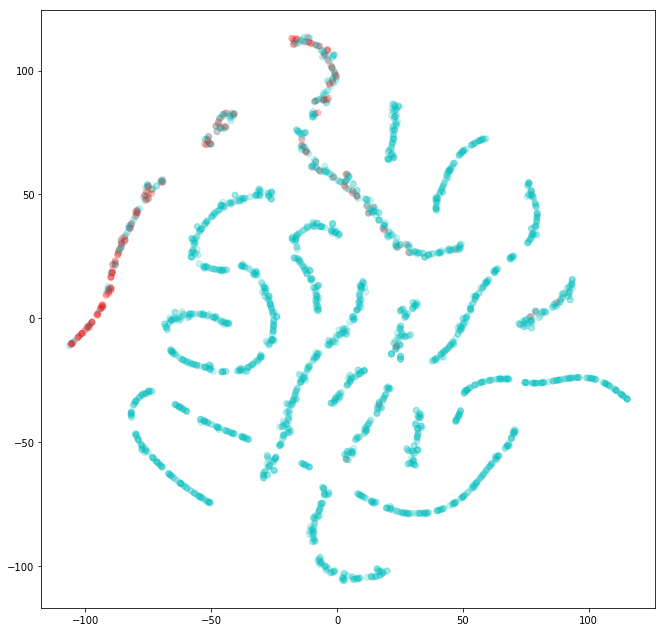

In [137]:
tsne_model = TSNE(n_components=2, random_state=0, perplexity = 10, learning_rate = 20, n_iter = 4000)
tsne_dist = tsne_model.fit_transform(m_z.detach().numpy())

fig = plt.figure(figsize=(11,11))
ax = fig.add_subplot(111)

plt.scatter(tsne_dist[:,0], tsne_dist[:,1],alpha = 0.20, c = ['c' if k==0 else 'r' for k in m_y.detach().numpy()])
plt.show()

## Clustering

In [138]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=30)
clusterer.fit(tsne_dist)    
cls_labels = clusterer.labels_
len(set(cls_labels))
colors = np.array([x for x in 'bgrcmybgrcmybgrcmybgrcmybgrcmy'])
colors = np.hstack([colors] * 100 + ['k'])

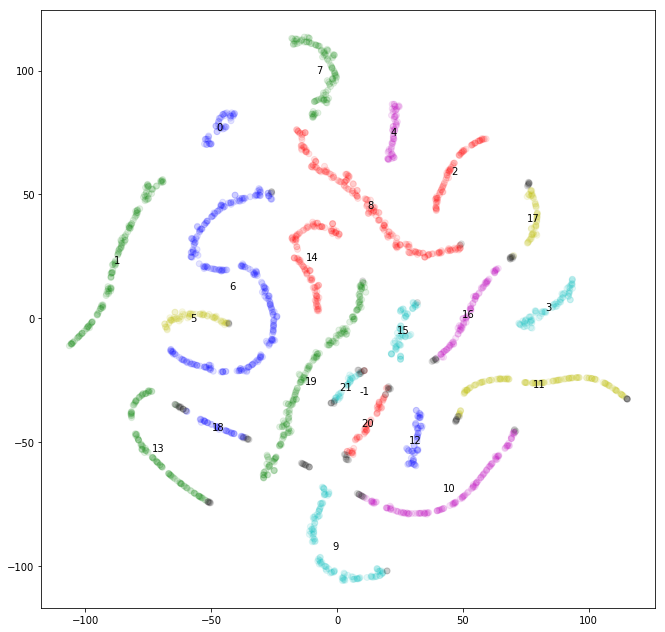

In [139]:
fig = plt.figure(figsize=(11,11))
ax = fig.add_subplot(111)
for i in set(cls_labels):
    coor = np.mean(tsne_dist[cls_labels==i,:],axis=0)
    ax.text(coor[0],coor[1], str(i), ha='center', va='center')

plt.scatter(tsne_dist[:,0], tsne_dist[:,1],alpha = 0.10, c =colors[cls_labels].tolist())
plt.show()

I decided to divide the cluster `1` into two because of the different `TripleNegative` rates we observe in different subsets of this clusters

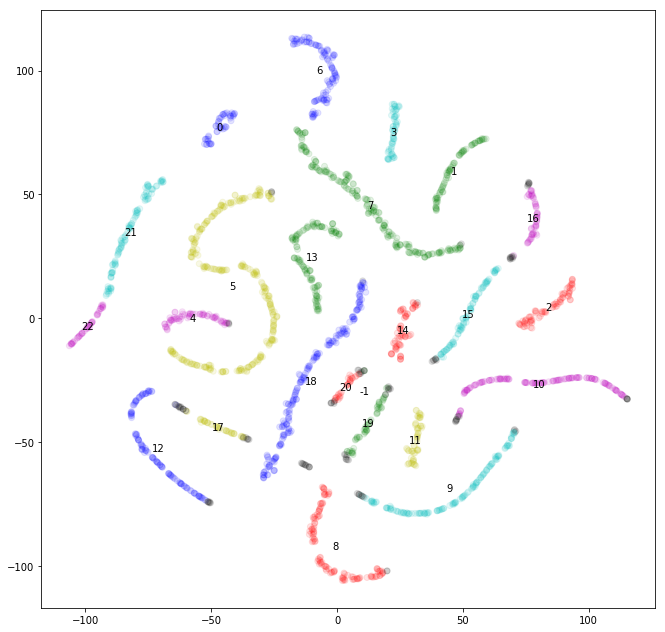

In [140]:
clus_id_div = 1; id_add = 100; num_of_clus = 2; n_neighbors = 15
knn_graph = kneighbors_graph(tsne_dist[cls_labels==clus_id_div], n_neighbors, include_self=False)

clusmodel = AgglomerativeClustering(linkage='ward',
                                connectivity=knn_graph,
                                n_clusters=num_of_clus)
clusmodel.fit(tsne_dist[cls_labels==clus_id_div])
cls_labels_new = clusmodel.labels_

labels_temp = cls_labels.copy()
labels_temp[cls_labels==clus_id_div] = cls_labels_new + id_add
dict_new_clus_ids = {b:(-1 if b == -1 else a) for a,b in enumerate(set(labels_temp))}
labels_temp = np.array([dict_new_clus_ids[k] for k in labels_temp])

fig = plt.figure(figsize=(11,11))
ax = fig.add_subplot(111)
for i in set(labels_temp):
    coor = np.mean(tsne_dist[labels_temp==i,:],axis=0)
    ax.text(coor[0],coor[1], str(i), ha='center', va='center')

plt.scatter(tsne_dist[:,0], tsne_dist[:,1],alpha = 0.10, c =colors[labels_temp].tolist())
plt.show()

In [121]:
np.savetxt('cluster_assignments.csv', np.vstack((patient_ids,labels_temp)).T,delimiter='\t')

In [ ]:
#ds_train = NYULH_DS(train_x_f, train_x_c, train_x_rep_list_np, train_x_country_np, y[train_ind])

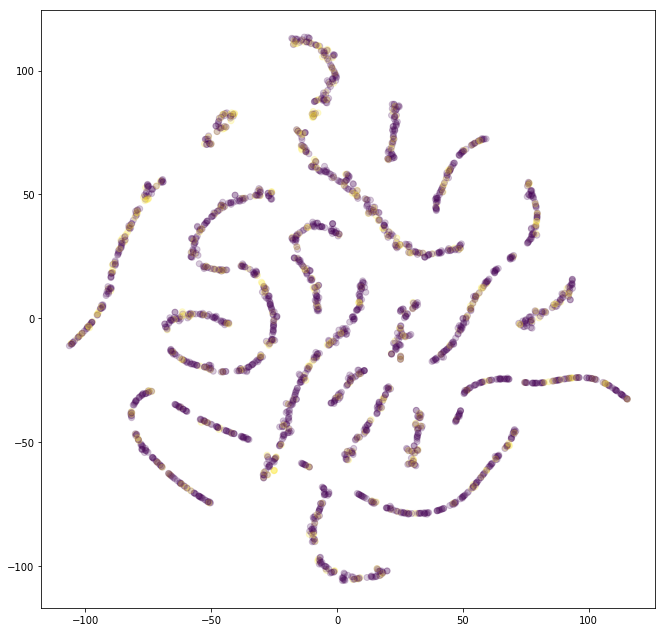

In [199]:
fig = plt.figure(figsize=(11,11))
ax = fig.add_subplot(111)

plt.scatter(tsne_dist[:,0], tsne_dist[:,1],alpha = 0.20, c = (medData_categ['Sleeping or reclining (time per day)'].iloc[train_ind].values==3).astype('float32'))
plt.show()

In [310]:
categs_json = read_enum_dict()

In [339]:
df_corr = pd.DataFrame(np.hstack((labels_temp[:,None], train_x_f,train_x_c)), columns=['cluster']+list(medData_float.columns)+list(medData_categ.columns))

In [340]:
dummy_cols=[]
dummy_cols_map = {}
target_cols = []
for k in ['cluster']+list(medData_categ.columns):
    df_corr[k] = df_corr[k].astype('category')
for k in ['cluster']:
    for val in df_corr[k].cat.categories:
        df_corr[k+'|'+str(val)] = (df_corr[k] == val).astype('int32').astype('category')
        target_cols.append(k+'|'+str(val))
for k in list(medData_categ.columns):
    for val in df_corr[k].cat.categories:
        df_corr[k+'|'+str(val)] = (df_corr[k] == val).astype('int32').astype('category')
        dummy_cols.append(k+'|'+str(val))
        dummy_cols_map[k+'|'+str(val)] = k+'|'+str(val) + '|'+', '.join([a for a,b in categs_json[k].items() if b ==int(val)]) 

In [341]:
MI_dict = defaultdict(lambda:[])
for lb1 in dummy_cols: 
    for lb2 in target_cols:
        MI_score = adjusted_mutual_info_score(df_corr[lb1].values,df_corr[lb2].values)
        corr_coef = df_corr[lb1].corr(df_corr[lb2])
        p1 = ((df_corr[lb1] == 1)&(df_corr[lb2] == 1)).sum() / (df_corr[lb1] == 1).sum()
        p2 = ((df_corr[lb1] == 1)&(df_corr[lb2] == 1)).sum() / (df_corr[lb2] == 1).sum()
        MI_dict[lb2].append((MI_score,corr_coef, dummy_cols_map[lb1], p1, p2))

In [351]:
with open('correlation_categ.csv','w') as f:
    f.write('Cluster\tMI\tCorrelation\tLabel\t(%) Label\t(%) Cluster\n')
    for c in target_cols:
        for a in sorted(MI_dict[c],reverse=True):
            f.write(c+'\t'+'\t'.join([str(k) for k in a]))
            f.write('\n')